# Import

In [6]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from tqdm import tqdm

from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler as ss, MinMaxScaler as mms, OneHotEncoder as ohe
from sklearn.decomposition import PCA

from sklearn.ensemble import HistGradientBoostingRegressor as hgb
from lightgbm import LGBMRegressor as lgbm
from xgboost import XGBRegressor as xgb
from catboost import CatBoostRegressor as cat
from sklego.linear_model import LADRegression as lad

plt.rc('font', family='Malgun Gothic')

import warnings
warnings.filterwarnings('ignore')

In [7]:
# seed 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

# Load Data

In [8]:
train = pd.read_csv('./open/train.csv').drop('ID',axis=1)
test = pd.read_csv('./open/test.csv').drop('ID',axis=1)
submission = pd.read_csv('./open/sample_submission.csv')

# Feature Engineering & Preprocessing

In [9]:
# 배기량을 기준으로 컬럼 추가
lst = []
for val in tqdm(train['배기량']):
    if val > 2000:
        lst.append('대형')
    elif val > 1600:
        lst.append('중형')
    elif val > 1000:
        lst.append('소형')
    else:
        lst.append('경형')

train['배기량별 구분'] = lst

lst = []
for val in tqdm(test['배기량']):
    if val > 2000:
        lst.append('대형')
    elif val > 1600:
        lst.append('중형')
    elif val > 1000:
        lst.append('소형')
    else:
        lst.append('경형')

test['배기량별 구분'] = lst

train['연간 자동차세'] = 0
train.loc[train['배기량별 구분']=='경형','연간 자동차세'] = train['배기량'] * 90
train.loc[train['배기량별 구분']=='소형','연간 자동차세'] = train['배기량'] * 140
train.loc[np.logical_or(train['배기량별 구분']=='중형', train['배기량별 구분']=='대형'),'연간 자동차세'] = train['배기량'] * 220

test['연간 자동차세'] = 0
test.loc[test['배기량별 구분']=='경형','연간 자동차세'] = test['배기량'] * 90
test.loc[test['배기량별 구분']=='소형','연간 자동차세'] = test['배기량'] * 140
test.loc[np.logical_or(test['배기량별 구분']=='중형', test['배기량별 구분']=='대형'),'연간 자동차세'] = test['배기량'] * 220

train['지방교육세'] = train['연간 자동차세'] * .3
test['지방교육세'] = test['연간 자동차세'] * .3

train['총 자동차세'] = train['연간 자동차세'] + train['지방교육세']
test['총 자동차세'] = test['연간 자동차세'] + test['지방교육세']

lst = []
for val in tqdm(train['배기량']):
    if val > 3800:
        lst.append('8기통')
    elif val > 2900:
        lst.append('6기통')
    elif val > 1400:
        lst.append('4기통')
    else:
        lst.append('3기통')

train['배기량별 구분2'] = lst

lst = []
for val in tqdm(test['배기량']):
    if val > 3800:
        lst.append('8기통')
    elif val > 2900:
        lst.append('6기통')
    elif val > 1400:
        lst.append('4기통')
    else:
        lst.append('3기통')

test['배기량별 구분2'] = lst

# 생산년도, 출시년도를 기준으로 컬럼 추가 및 자동차세 할인 적용
train['생산이후'] = 2023 - train['생산년도']
train['모델출시이후'] = 2023 - train['모델출시년도']

test['생산이후'] = 2023 - test['생산년도']
test['모델출시이후'] = 2023 - test['모델출시년도']

train['자동차세 할인 여부'] = 0
train.loc[train['생산이후']>=3,'자동차세 할인 여부'] = 1

test['자동차세 할인 여부'] = 0
test.loc[test['생산이후']>=3,'자동차세 할인 여부'] = 1

train['할인 후 자동차세'] = 0
train.loc[train['생산이후']>=3,'할인 후 자동차세'] = (train['연간 자동차세'] + train['지방교육세'])*(1 - (train['생산이후']-2)*.05)
train.loc[train['생산이후']>=13,'할인 후 자동차세'] = (train['연간 자동차세'] + train['지방교육세'])*.5

test['할인 후 자동차세'] = 0
test.loc[test['생산이후']>=3,'할인 후 자동차세'] = (test['연간 자동차세'] + test['지방교육세'])*(1 - (test['생산이후']-2)*.05)
test.loc[test['생산이후']>=13,'할인 후 자동차세'] = (test['연간 자동차세'] + test['지방교육세'])*.5

train['일반보증'] = 0
train.loc[np.logical_or(train['생산이후']<=3, train['주행거리']<=60000),'일반보증'] = 1

test['일반보증'] = 0
test.loc[np.logical_or(test['생산이후']<=3, test['주행거리']<=60000),'일반보증'] = 1

train['엔진보증'] = 0
train.loc[np.logical_or(train['생산이후']<=5, train['주행거리']<=100000),'엔진보증'] = 1

test['엔진보증'] = 0
test.loc[np.logical_or(test['생산이후']<=5, test['주행거리']<=100000),'엔진보증'] = 1

100%|██████████| 14480/14480 [00:00<00:00, 4827016.53it/s]


In [10]:
# 브랜드, 차량모델명, 판매도시, 판매구역 가격을 기준으로 랭크 인코딩
brand_idx = train[['브랜드','가격']].groupby(['브랜드']).mean().sort_values('가격').index
dict_brand = {}
for i in range(len(brand_idx)):
    key = brand_idx[i]
    value = i
    dict_brand[key] = value

train['브랜드'] = train['브랜드'].map(dict_brand)
test['브랜드'] = test['브랜드'].map(dict_brand)

model_idx = train[['차량모델명','가격']].groupby(['차량모델명']).mean().sort_values('가격').index
dict_model = {}
for i in range(len(model_idx)):
    key = model_idx[i]
    value = i
    dict_model[key] = value

train['차량모델명'] = train['차량모델명'].map(dict_model)
test['차량모델명'] = test['차량모델명'].map(dict_model)

city_idx = train[['판매도시','가격']].groupby(['판매도시']).mean().sort_values('가격').index
dict_city = {}
for i in range(len(city_idx)):
    key = city_idx[i]
    value = i
    dict_city[key] = value

train['판매도시'] = train['판매도시'].map(dict_city)
test['판매도시'] = test['판매도시'].map(dict_city)

sector_idx = train[['판매구역','가격']].groupby(['판매구역']).mean().sort_values('가격').index
dict_sector = {}
for i in range(len(sector_idx)):
    key = sector_idx[i]
    value = i
    dict_sector[key] = value

train['판매구역'] = train['판매구역'].map(dict_sector)
test['판매구역'] = test['판매구역'].map(dict_sector)

In [14]:
# 범주형 컬럼 원-핫 인코딩
encoder = ohe(sparse=False)

onehot = pd.DataFrame(encoder.fit_transform(train[['배기량별 구분','배기량별 구분2']]), columns=list(encoder.categories_[0])+ list(encoder.categories_[1]))
train = pd.concat([train.drop(encoder.feature_names_in_, axis=1), onehot], axis=1)

onehot2 = pd.DataFrame(encoder.transform(test[['배기량별 구분','배기량별 구분2']]), columns=list(encoder.categories_[0])+ list(encoder.categories_[1]))
test = pd.concat([test.drop(encoder.feature_names_in_, axis=1), onehot2], axis=1)

In [15]:
# 주행거리 컬럼의 이상치 제거
Q3 = np.quantile(train['주행거리'],.75)
Q1 = np.quantile(train['주행거리'],.25)
IQR = Q3 - Q1
maximum = Q3 + (1.5*IQR)
train['주행거리_이상치'] = 0
train.loc[train['주행거리']>maximum,'주행거리_이상치'] = 1

train = train.drop(index=train[train['주행거리_이상치']==1].index).reset_index().drop(['index','주행거리_이상치'],axis=1)

In [17]:
# 상관관계 파악을 위해 가격(target) 컬럼을 맨 후측으로 이동
train['target'] = train['가격']
train.drop('가격', axis=1, inplace=True)

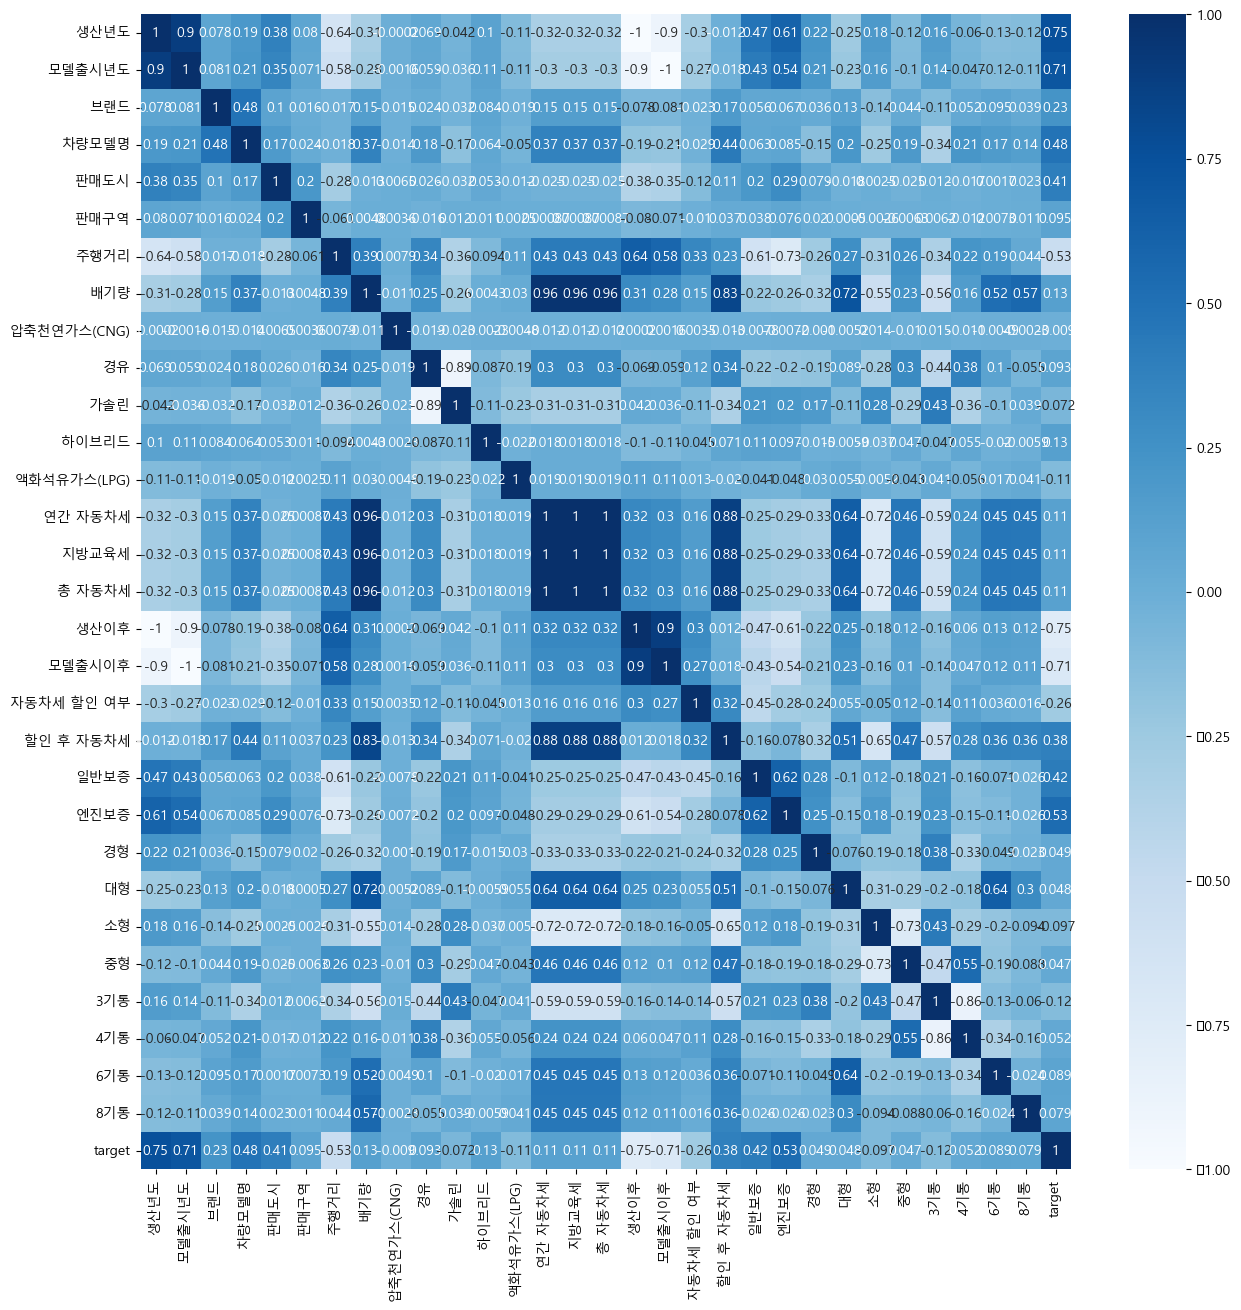

In [19]:
plt.figure(figsize = (15,15))
sns.heatmap(train.corr(), annot = True, cmap = 'Blues')
plt.show()

In [20]:
# 종속변수, 독립변수 분리
train_x = train.drop('target',axis=1)
train_y = train['target']
test_x = test

In [28]:
# StandardScaler, MinMaxScaler 비교
scaler = ss()
scaler2 = mms()

stand_cols = ['생산년도','모델출시년도','브랜드','차량모델명','판매도시','판매구역','주행거리','배기량','연간 자동차세','지방교육세','총 자동차세','생산이후','모델출시이후','할인 후 자동차세']
train_standard = pd.DataFrame(scaler.fit_transform(train_x[stand_cols]), columns=stand_cols)
test_standard = pd.DataFrame(scaler.transform(test_x[stand_cols]), columns=stand_cols)

non_stand = list(train_x.columns)
for stand_col in stand_cols:
    non_stand.remove(stand_col)

train_standard = pd.concat([train_standard, train_x[non_stand]], axis=1)
test_standard = pd.concat([test_standard, test_x[non_stand]], axis=1)


train_minmax = pd.DataFrame(scaler2.fit_transform(train_x), columns=train_x.columns)
test_minmax = pd.DataFrame(scaler2.transform(test_x), columns=test_x.columns)

In [31]:
# 주성분 분석을 통한 차원압축
# 생산, 출시년도 관련 컬럼 압축

# standard data
pca = PCA(n_components=1)
pca.fit(train_standard[['생산년도','모델출시년도','생산이후','모델출시이후']])
print('standard data pca_1: ', pca.explained_variance_ratio_)

# minmax data
pca2 = PCA(n_components=1)
pca2.fit(train_minmax[['생산년도','모델출시년도','생산이후','모델출시이후']])
print('minmax data pca_1: ', pca2.explained_variance_ratio_)

standard data pca_1:  [0.94917884]
minmax data pca_1:  [0.95006817]


In [32]:
# standard data
train_standard['생산출시PCA'] = pca.transform(train_standard[['생산년도','모델출시년도','생산이후','모델출시이후']])
train_standard.drop(['생산년도','모델출시년도','생산이후','모델출시이후'],axis=1,inplace=True)

test_standard['생산출시PCA'] = pca.transform(test_standard[['생산년도','모델출시년도','생산이후','모델출시이후']])
test_standard.drop(['생산년도','모델출시년도','생산이후','모델출시이후'],axis=1,inplace=True)

# minmax data
train_minmax['생산출시PCA'] = pca2.transform(train_minmax[['생산년도','모델출시년도','생산이후','모델출시이후']])
train_minmax.drop(['생산년도','모델출시년도','생산이후','모델출시이후'],axis=1,inplace=True)

test_minmax['생산출시PCA'] = pca2.transform(test_minmax[['생산년도','모델출시년도','생산이후','모델출시이후']])
test_minmax.drop(['생산년도','모델출시년도','생산이후','모델출시이후'],axis=1,inplace=True)

In [33]:
# 배기량 관련 컬럼 압축

# standard data
pca3 = PCA(n_components=1)
pca3.fit(train_standard[['배기량','연간 자동차세','지방교육세','총 자동차세']])
print('standard data pca_1: ', pca3.explained_variance_ratio_)

# minmax data
pca4 = PCA(n_components=1)
pca4.fit(train_minmax[['배기량','연간 자동차세','지방교육세','총 자동차세']])
print('minmax data pca_1: ', pca4.explained_variance_ratio_)

standard data pca_1:  [0.98596352]
minmax data pca_1:  [0.98926083]


In [34]:
# standard data
train_standard['배기량PCA'] = pca3.transform(train_standard[['배기량','연간 자동차세','지방교육세','총 자동차세']])
train_standard.drop(['배기량','연간 자동차세','지방교육세','총 자동차세'],axis=1,inplace=True)

test_standard['배기량PCA'] = pca3.transform(test_standard[['배기량','연간 자동차세','지방교육세','총 자동차세']])
test_standard.drop(['배기량','연간 자동차세','지방교육세','총 자동차세'],axis=1,inplace=True)

# minmax data
train_minmax['배기량PCA'] = pca4.transform(train_minmax[['배기량','연간 자동차세','지방교육세','총 자동차세']])
train_minmax.drop(['배기량','연간 자동차세','지방교육세','총 자동차세'],axis=1,inplace=True)

test_minmax['배기량PCA'] = pca4.transform(test_minmax[['배기량','연간 자동차세','지방교육세','총 자동차세']])
test_minmax.drop(['배기량','연간 자동차세','지방교육세','총 자동차세'],axis=1,inplace=True)

In [46]:
display(train_y.head(2))

0    51.74
1    41.47
Name: target, dtype: float64

In [45]:
display(train_standard.head(2)
,test_standard.head(2))

,브랜드,차량모델명,판매도시,판매구역,주행거리,할인 후 자동차세,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG),자동차세 할인 여부,일반보증,엔진보증,경형,대형,소형,중형,3기통,4기통,6기통,8기통,생산출시PCA,배기량PCA
0,1.487846,-0.760757,0.928706,0.598046,-1.015180,-1.219919,0,0,1,0,0,1,0,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-2.449302,-2.970534
1,1.118780,0.617587,-0.687017,-2.120738,-0.386675,-0.856985,0,0,1,0,0,1,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.683093,-1.197290


,브랜드,차량모델명,판매도시,판매구역,주행거리,할인 후 자동차세,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG),자동차세 할인 여부,일반보증,엔진보증,경형,대형,소형,중형,3기통,4기통,6기통,8기통,생산출시PCA,배기량PCA
0,0.011582,0.519134,0.897180,-0.308215,-1.371694,1.598875,0,0,1,0,0,1,1,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-2.057753,1.148352
1,-0.542017,-1.449929,0.376996,-1.214477,-0.083592,-1.112211,0,0,1,0,0,1,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.094092,-1.978560


In [42]:
display(train_minmax.head(2)
,test_minmax.head(2))

,브랜드,차량모델명,판매도시,판매구역,주행거리,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG),자동차세 할인 여부,할인 후 자동차세,일반보증,엔진보증,경형,대형,소형,중형,3기통,4기통,6기통,8기통,생산출시PCA,배기량PCA
0,0.894737,0.309859,0.843575,0.75,0.222833,0.0,0.0,1.0,0.0,0.0,1.0,0.105267,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.305346,-0.356368
1,0.789474,0.605634,0.525450,0.00,0.352953,0.0,0.0,1.0,0.0,0.0,1.0,0.154077,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.088047,-0.149427


,브랜드,차량모델명,판매도시,판매구역,주행거리,압축천연가스(CNG),경유,가솔린,하이브리드,액화석유가스(LPG),자동차세 할인 여부,할인 후 자동차세,일반보증,엔진보증,경형,대형,소형,중형,3기통,4기통,6기통,8기통,생산출시PCA,배기량PCA
0,0.473684,0.584507,0.837368,0.50,0.149023,0.0,0.0,1.0,0.0,0.0,1.0,0.484364,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.256172,0.141702
1,0.315789,0.161972,0.734947,0.25,0.415701,0.0,0.0,1.0,0.0,0.0,1.0,0.119752,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.010738,-0.236522


# Modeling

In [51]:
# train, validation 분리
tr_stand, val_stand, tr_stand_y, val_stand_y = train_test_split(train_standard, train_y, test_size=.15, random_state=42)
tr_minmax, val_minmax, tr_minmax_y, val_minmax_y = train_test_split(train_minmax, train_y, test_size=.15, random_state=42)

In [66]:
result_score_stand = {}
result_param_stand = {}

result_score_minmax = {}
result_param_minmax = {}

In [67]:
# optuna 파라미터 튜닝
def objectiveHGB_stand(trial:optuna.Trial, tr_stand, tr_stand_y, val_stand, val_stand_y):
    param = {
        "l2_regularization":trial.suggest_float('l2_regularization', 0, 0.1),
        "learning_rate":trial.suggest_float('learning_rate',0.01, 0.1),
        "max_depth":trial.suggest_int('max_depth', 5, 10),
        "min_samples_leaf":trial.suggest_int('min_samples_leaf', 20, 30),
        "max_leaf_nodes":trial.suggest_int('max_leaf_nodes', 2, 30)
    }
    model = hgb(**param, loss='absolute_error', max_iter=1000, max_bins=255, early_stopping=True, random_state=42)
    hgb_model = model.fit(tr_stand, tr_stand_y)

    score = mae(val_stand_y, hgb_model.predict(val_stand))

    return score

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(lambda trial:objectiveHGB_stand(trial, tr_stand, tr_stand_y, val_stand, val_stand_y), n_trials=50)
print('Best_HistGradientBoosting score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))
result_score_stand['HistGradientBoost'] = study.best_trial.value
result_param_stand['HistGradientBoost'] = study.best_trial.params

[I 2023-06-19 15:57:23,709] A new study created in memory with name: no-name-aab1f3db-8dba-4f61-a33b-5a71cc64017f
[I 2023-06-19 15:57:28,864] Trial 0 finished with value: 6.22892020551541 and parameters: {'l2_regularization': 0.07479481376155937, 'learning_rate': 0.07175037356658388, 'max_depth': 7, 'min_samples_leaf': 21, 'max_leaf_nodes': 15}. Best is trial 0 with value: 6.22892020551541.
[I 2023-06-19 15:57:32,623] Trial 1 finished with value: 7.508366883633813 and parameters: {'l2_regularization': 0.09085176288387709, 'learning_rate': 0.01443097282241505, 'max_depth': 6, 'min_samples_leaf': 29, 'max_leaf_nodes': 9}. Best is trial 0 with value: 6.22892020551541.
[I 2023-06-19 15:57:35,248] Trial 2 finished with value: 7.561875784201477 and parameters: {'l2_regularization': 0.011844591846629227, 'learning_rate': 0.032426345430372164, 'max_depth': 5, 'min_samples_leaf': 21, 'max_leaf_nodes': 5}. Best is trial 0 with value: 6.22892020551541.
[I 2023-06-19 15:57:38,166] Trial 3 finished

Best_HistGradientBoosting score 6.112459760422571, 
params {'l2_regularization': 0.01484508629034529, 'learning_rate': 0.05996118331121527, 'max_depth': 8, 'min_samples_leaf': 22, 'max_leaf_nodes': 30}


In [68]:
def objectiveHGB_minmax(trial:optuna.Trial, tr_minmax, tr_minmax_y, val_minmax, val_minmax_y):
    param = {
        "l2_regularization":trial.suggest_float('l2_regularization', 0, 0.1),
        "learning_rate":trial.suggest_float('learning_rate',0.01, 0.1),
        "max_depth":trial.suggest_int('max_depth', 5, 10),
        "min_samples_leaf":trial.suggest_int('min_samples_leaf', 20, 30),
        "max_leaf_nodes":trial.suggest_int('max_leaf_nodes', 2, 30)
    }
    model = hgb(**param, loss='absolute_error', max_iter=1000, max_bins=255, early_stopping=True, random_state=42)
    hgb_model = model.fit(tr_minmax, tr_minmax_y)

    score = mae(val_minmax_y, hgb_model.predict(val_minmax))

    return score

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(lambda trial:objectiveHGB_minmax(trial, tr_minmax, tr_minmax_y, val_minmax, val_minmax_y), n_trials=50)
print('Best_HistGradientBoosting score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))

result_score_minmax['HistGradientBoost'] = study.best_trial.value
result_param_minmax['HistGradientBoost'] = study.best_trial.params

[I 2023-06-19 16:01:37,760] A new study created in memory with name: no-name-6984827c-121e-42ba-b7a6-af58b21c3bdf
[I 2023-06-19 16:01:39,812] Trial 0 finished with value: 8.236724805287642 and parameters: {'l2_regularization': 0.09972842408258786, 'learning_rate': 0.04253369188755842, 'max_depth': 8, 'min_samples_leaf': 29, 'max_leaf_nodes': 3}. Best is trial 0 with value: 8.236724805287642.
[I 2023-06-19 16:01:42,455] Trial 1 finished with value: 6.9330759116140595 and parameters: {'l2_regularization': 0.04476931497075159, 'learning_rate': 0.07605505776943454, 'max_depth': 9, 'min_samples_leaf': 28, 'max_leaf_nodes': 5}. Best is trial 1 with value: 6.9330759116140595.
[I 2023-06-19 16:01:45,454] Trial 2 finished with value: 6.651762995272923 and parameters: {'l2_regularization': 0.03800351759285482, 'learning_rate': 0.08415482464034009, 'max_depth': 10, 'min_samples_leaf': 25, 'max_leaf_nodes': 6}. Best is trial 2 with value: 6.651762995272923.
[I 2023-06-19 16:01:53,080] Trial 3 fini

Best_HistGradientBoosting score 6.1452025061333755, 
params {'l2_regularization': 0.025632140121286947, 'learning_rate': 0.07557877010072207, 'max_depth': 8, 'min_samples_leaf': 23, 'max_leaf_nodes': 24}


In [82]:
def objectiveLGBM_stand(trial:optuna.Trial, tr_stand, tr_stand_y, val_stand, val_stand_y):
    param = {
        "max_bin":trial.suggest_int('max_bin', 255, 1000),
        "boosting_type":trial.suggest_categorical('boosting_type', ['gbdt','dart','rf']),
        "learning_rate":trial.suggest_categorical('learning_rate',[0.01, 0.03, 0.1]),
        "max_depth":trial.suggest_categorical('max_depth', [6, 10, None]),
        "num_leaves":trial.suggest_int('num_leaves', 50, 255),
        "reg_alpha":trial.suggest_categorical('reg_alpha', [0, 0.1]),
        "reg_lambda":trial.suggest_categorical('reg_lambda', [0, 0.1]),
        "importance_type":trial.suggest_categorical('importance_type', ['split','gain']),
        "subsample":trial.suggest_categorical('subsample', [0.4, 0.8, 1]),
        "data_sample_strategy":trial.suggest_categorical('data_sample_strategy', ['bagging','goss']),
        "tree_learner":trial.suggest_categorical('tree_learner', ['serial','feature','data','voting'])
    }
    model = lgbm(objective='mae', metric='mae', n_estimators=5000, random_state=42)
    lgbm_model = model.fit(tr_stand, tr_stand_y, eval_set=(val_stand, val_stand_y), eval_metric='mae', verbose=False, early_stopping_rounds=1000)
    # lgbm_model = model.fit(tr_stand, tr_stand_y, verbose=False)

    score = mae(val_stand_y, lgbm_model.predict(val_stand))

    return score

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(lambda trial:objectiveLGBM_stand(trial, tr_stand, tr_stand_y, val_stand, val_stand_y), n_trials=50)
print('Best_LGBM score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))
result_score_stand['LGBM'] = study.best_trial.value
result_param_stand['LGBM'] = study.best_trial.params

[I 2023-06-19 16:30:03,068] A new study created in memory with name: no-name-21bd7b19-04b5-420b-adaf-e7da78468236
[I 2023-06-19 16:30:10,290] Trial 0 finished with value: 6.057646978556866 and parameters: {'max_bin': 537, 'boosting_type': 'rf', 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 224, 'reg_alpha': 0, 'reg_lambda': 0, 'importance_type': 'split', 'subsample': 0.4, 'data_sample_strategy': 'bagging', 'tree_learner': 'data'}. Best is trial 0 with value: 6.057646978556866.
[I 2023-06-19 16:30:17,329] Trial 1 finished with value: 6.057646978556866 and parameters: {'max_bin': 810, 'boosting_type': 'gbdt', 'learning_rate': 0.03, 'max_depth': 10, 'num_leaves': 152, 'reg_alpha': 0, 'reg_lambda': 0, 'importance_type': 'split', 'subsample': 1, 'data_sample_strategy': 'bagging', 'tree_learner': 'data'}. Best is trial 0 with value: 6.057646978556866.
[I 2023-06-19 16:30:24,444] Trial 2 finished with value: 6.057646978556866 and parameters: {'max_bin': 952, 'boosting_type': 'rf', 'le

Best_LGBM score 6.057646978556866, 
params {'max_bin': 537, 'boosting_type': 'rf', 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 224, 'reg_alpha': 0, 'reg_lambda': 0, 'importance_type': 'split', 'subsample': 0.4, 'data_sample_strategy': 'bagging', 'tree_learner': 'data'}


In [83]:
def objectiveLGBM_minmax(trial:optuna.Trial, tr_minmax, tr_minmax_y, val_minmax, val_minmax_y):
    param = {
        "max_bin":trial.suggest_int('max_bin', 255, 1000),
        "boosting_type":trial.suggest_categorical('boosting_type', ['gbdt','dart','rf']),
        "learning_rate":trial.suggest_categorical('learning_rate',[0.01, 0.03, 0.1]),
        "max_depth":trial.suggest_categorical('max_depth', [6, 10, None]),
        "num_leaves":trial.suggest_int('num_leaves', 50, 255),
        "reg_alpha":trial.suggest_categorical('reg_alpha', [0, 0.1]),
        "reg_lambda":trial.suggest_categorical('reg_lambda', [0, 0.1]),
        "importance_type":trial.suggest_categorical('importance_type', ['split','gain']),
        "subsample":trial.suggest_categorical('subsample', [0.4, 0.8, 1]),
        "data_sample_strategy":trial.suggest_categorical('data_sample_strategy', ['bagging','goss']),
        "tree_learner":trial.suggest_categorical('tree_learner', ['serial','feature','data','voting'])
    }
    model = lgbm(objective='mae', metric='mae', n_estimators=5000, random_state=42)
    lgbm_model = model.fit(tr_minmax, tr_minmax_y, eval_set=(val_minmax, val_minmax_y), eval_metric='mae', verbose=False, early_stopping_rounds=1000)
    # lgbm_model = model.fit(tr_minmax, tr_minmax_y, verbose=False)

    score = mae(val_minmax_y, lgbm_model.predict(val_minmax))

    return score

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(lambda trial:objectiveLGBM_minmax(trial, tr_minmax, tr_minmax_y, val_minmax, val_minmax_y), n_trials=50)
print('Best_LGBM score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))
result_score_minmax['LGBM'] = study.best_trial.value
result_param_minmax['LGBM'] = study.best_trial.params

[I 2023-06-19 16:36:17,585] A new study created in memory with name: no-name-a8a338b7-c84c-4544-b74c-792b30d60ac4
[I 2023-06-19 16:36:25,551] Trial 0 finished with value: 6.05453533323424 and parameters: {'max_bin': 451, 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 6, 'num_leaves': 214, 'reg_alpha': 0, 'reg_lambda': 0.1, 'importance_type': 'split', 'subsample': 0.4, 'data_sample_strategy': 'bagging', 'tree_learner': 'serial'}. Best is trial 0 with value: 6.05453533323424.
[I 2023-06-19 16:36:33,257] Trial 1 finished with value: 6.05453533323424 and parameters: {'max_bin': 545, 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': None, 'num_leaves': 166, 'reg_alpha': 0, 'reg_lambda': 0.1, 'importance_type': 'split', 'subsample': 1, 'data_sample_strategy': 'goss', 'tree_learner': 'voting'}. Best is trial 0 with value: 6.05453533323424.
[I 2023-06-19 16:36:40,983] Trial 2 finished with value: 6.05453533323424 and parameters: {'max_bin': 556, 'boosting_type': 'rf', 'l

Best_LGBM score 6.05453533323424, 
params {'max_bin': 451, 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 6, 'num_leaves': 214, 'reg_alpha': 0, 'reg_lambda': 0.1, 'importance_type': 'split', 'subsample': 0.4, 'data_sample_strategy': 'bagging', 'tree_learner': 'serial'}


In [86]:
def objectiveXGB_stand(trial:optuna.Trial, tr_stand, tr_stand_y, val_stand, val_stand_y):
    param = {
        "booster":trial.suggest_categorical('booster',['gbtree','gblinear','dart']),
        "learning_rate":trial.suggest_categorical('learning_rate',[0.01, 0.03, 0.1]),
        "gamma":trial.suggest_categorical('gamma', [0, 0.6, 1]),
        "max_depth":trial.suggest_categorical('max_depth', [6, 10, None]),
        "min_child_weight":trial.suggest_int('min_child_weight', 1, 20),
        "subsample":trial.suggest_float('subsample', 0.8, 1),
        "sampling_method":trial.suggest_categorical('sampling_method', ['uniform', 'gradient_based']),
        "colsample_bytree":trial.suggest_categorical('colsample_bytree', [0.9, 1]),
        "colsample_bylevel":trial.suggest_float('colsample_bylevel', 0.8, 1),
        "colsample_bynode":trial.suggest_float('colsample_bynode', 0.8, 1),
        "reg_alpha":trial.suggest_categorical('reg_alpha', [0, 0.1]),
        "reg_lambda":trial.suggest_categorical('reg_lambda', [0, 0.5, 1]),
        "tree_method":trial.suggest_categorical('tree_method', ['auto', 'exact', 'approx', 'hist']),
        "process_type":trial.suggest_categorical('process_type', ['default', 'update']),
        "grow_policy":trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        "max_bin":trial.suggest_int('max_bin', 255, 1000),
        "sample_type":trial.suggest_categorical('sample_type', ['uniform', 'weighted']),
        "normalize_type":trial.suggest_categorical('normalize_type', ['tree', 'forest']),
        "rate_drop":trial.suggest_float('rate_drop', 0, 0.5),
        "skip_drop":trial.suggest_float('skip_drop', 0, 0.5),
        "updator":trial.suggest_categorical('updator', ['shotgun', 'coord_desent']),
        "feature_selector":trial.suggest_categorical('feature_selector', ['cyclic', 'shuffle', 'random','thrifty']),
        "base_score":trial.suggest_categorical('base_score', [0.5, 0.8, 1])
    }
    model = xgb(objective='reg:absoluteerror', eval_metric='mae', n_estimators=5000, random_state=42)
    xgb_model = model.fit(tr_stand, tr_stand_y, eval_set=[(val_stand, val_stand_y)], early_stopping_rounds=1000, verbose=False)

    score = mae(val_stand_y, xgb_model.predict(val_stand))

    return score

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(lambda trial:objectiveXGB_stand(trial, tr_stand, tr_stand_y, val_stand, val_stand_y), n_trials=50)
print('Best_xgb score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))
result_score_stand['XGB'] = study.best_trial.value
result_param_stand['XGB'] = study.best_trial.params

[I 2023-06-19 17:02:45,735] A new study created in memory with name: no-name-6785541a-c1d3-433b-b0c7-59ea0e1b986c
[I 2023-06-19 17:03:00,923] Trial 0 finished with value: 6.420623023859195 and parameters: {'booster': 'gblinear', 'learning_rate': 0.01, 'gamma': 0, 'max_depth': None, 'min_child_weight': 12, 'subsample': 0.8588743402455521, 'sampling_method': 'uniform', 'colsample_bytree': 1, 'colsample_bylevel': 0.9561277033884574, 'colsample_bynode': 0.9636989044722555, 'reg_alpha': 0, 'reg_lambda': 1, 'tree_method': 'exact', 'process_type': 'update', 'grow_policy': 'depthwise', 'max_bin': 834, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.09011737221213328, 'skip_drop': 0.4514864100320655, 'updator': 'coord_desent', 'feature_selector': 'thrifty', 'base_score': 0.5}. Best is trial 0 with value: 6.420623023859195.
[I 2023-06-19 17:03:15,864] Trial 1 finished with value: 6.420623023859195 and parameters: {'booster': 'dart', 'learning_rate': 0.03, 'gamma': 0, 'max_d

Best_xgb score 6.420623023859195, 
params {'booster': 'gblinear', 'learning_rate': 0.01, 'gamma': 0, 'max_depth': None, 'min_child_weight': 12, 'subsample': 0.8588743402455521, 'sampling_method': 'uniform', 'colsample_bytree': 1, 'colsample_bylevel': 0.9561277033884574, 'colsample_bynode': 0.9636989044722555, 'reg_alpha': 0, 'reg_lambda': 1, 'tree_method': 'exact', 'process_type': 'update', 'grow_policy': 'depthwise', 'max_bin': 834, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.09011737221213328, 'skip_drop': 0.4514864100320655, 'updator': 'coord_desent', 'feature_selector': 'thrifty', 'base_score': 0.5}


In [87]:
def objectiveXGB_minmax(trial:optuna.Trial, tr_minmax, tr_minmax_y, val_minmax, val_minmax_y):
    param = {
        "booster":trial.suggest_categorical('booster',['gbtree','gblinear','dart']),
        "learning_rate":trial.suggest_categorical('learning_rate',[0.01, 0.03, 0.1]),
        "gamma":trial.suggest_categorical('gamma', [0, 0.6, 1]),
        "max_depth":trial.suggest_categorical('max_depth', [6, 10, None]),
        "min_child_weight":trial.suggest_int('min_child_weight', 1, 20),
        "subsample":trial.suggest_float('subsample', 0.8, 1),
        "sampling_method":trial.suggest_categorical('sampling_method', ['uniform', 'gradient_based']),
        "colsample_bytree":trial.suggest_categorical('colsample_bytree', [0.9, 1]),
        "colsample_bylevel":trial.suggest_float('colsample_bylevel', 0.8, 1),
        "colsample_bynode":trial.suggest_float('colsample_bynode', 0.8, 1),
        "reg_alpha":trial.suggest_categorical('reg_alpha', [0, 0.1]),
        "reg_lambda":trial.suggest_categorical('reg_lambda', [0, 0.5, 1]),
        "tree_method":trial.suggest_categorical('tree_method', ['auto', 'exact', 'approx', 'hist']),
        "process_type":trial.suggest_categorical('process_type', ['default', 'update']),
        "grow_policy":trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        "max_bin":trial.suggest_int('max_bin', 255, 1000),
        "sample_type":trial.suggest_categorical('sample_type', ['uniform', 'weighted']),
        "normalize_type":trial.suggest_categorical('normalize_type', ['tree', 'forest']),
        "rate_drop":trial.suggest_float('rate_drop', 0, 0.5),
        "skip_drop":trial.suggest_float('skip_drop', 0, 0.5),
        "updator":trial.suggest_categorical('updator', ['shotgun', 'coord_desent']),
        "feature_selector":trial.suggest_categorical('feature_selector', ['cyclic', 'shuffle', 'random','thrifty']),
        "base_score":trial.suggest_categorical('base_score', [0.5, 0.8, 1])
    }
    model = xgb(objective='reg:absoluteerror', eval_metric='mae', n_estimators=5000, random_state=42)
    xgb_model = model.fit(tr_minmax, tr_minmax_y, eval_set=[(val_minmax, val_minmax_y)], early_stopping_rounds=1000, verbose=False)

    score = mae(val_minmax_y, xgb_model.predict(val_minmax))

    return score

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(lambda trial:objectiveXGB_minmax(trial, tr_minmax, tr_minmax_y, val_minmax, val_minmax_y), n_trials=50)
print('Best_xgb score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))
result_score_minmax['XGB'] = study.best_trial.value
result_param_minmax['XGB'] = study.best_trial.params

[I 2023-06-19 17:15:56,424] A new study created in memory with name: no-name-5905aa23-8bd4-42ae-8362-359ee9ae9dc6
[I 2023-06-19 17:16:09,677] Trial 0 finished with value: 6.42751528738103 and parameters: {'booster': 'gblinear', 'learning_rate': 0.1, 'gamma': 0, 'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.861057486958555, 'sampling_method': 'gradient_based', 'colsample_bytree': 1, 'colsample_bylevel': 0.9186582181351606, 'colsample_bynode': 0.9442776711990324, 'reg_alpha': 0, 'reg_lambda': 0.5, 'tree_method': 'auto', 'process_type': 'default', 'grow_policy': 'depthwise', 'max_bin': 898, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.2838320011916894, 'skip_drop': 0.28945999149423357, 'updator': 'coord_desent', 'feature_selector': 'random', 'base_score': 0.8}. Best is trial 0 with value: 6.42751528738103.
[I 2023-06-19 17:16:23,265] Trial 1 finished with value: 6.42751528738103 and parameters: {'booster': 'dart', 'learning_rate': 0.1, 'gamma': 1, 'max_de

Best_xgb score 6.42751528738103, 
params {'booster': 'gblinear', 'learning_rate': 0.1, 'gamma': 0, 'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.861057486958555, 'sampling_method': 'gradient_based', 'colsample_bytree': 1, 'colsample_bylevel': 0.9186582181351606, 'colsample_bynode': 0.9442776711990324, 'reg_alpha': 0, 'reg_lambda': 0.5, 'tree_method': 'auto', 'process_type': 'default', 'grow_policy': 'depthwise', 'max_bin': 898, 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.2838320011916894, 'skip_drop': 0.28945999149423357, 'updator': 'coord_desent', 'feature_selector': 'random', 'base_score': 0.8}


In [91]:
def objectiveCAT_stand(trial:optuna.Trial, tr_stand, tr_stand_y, val_stand, val_stand_y):
    param = {
        "learning_rate":trial.suggest_categorical('learning_rate',[0.01, 0.03, 0.1]),
        "depth":trial.suggest_categorical('depth', [6, 10, None]),
        "random_strength":trial.suggest_float('random_strength', 0, 0.5),
        "bagging_temperature":trial.suggest_float('bagging_temperature', 0, 1),
        "l2_leaf_reg":trial.suggest_categorical('l2_leaf_reg', [None, 0.001, 0.01]),
        "border_count":trial.suggest_categorical('border_count', [None, 254]),
        "grow_policy":trial.suggest_categorical('grow_policy', ['Depthwise', 'Lossguide','SymmetricTree']),
        "max_leaves":trial.suggest_int('max_leaves', 31, 64),
        "auto_class_weights":trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced', None]),
    }
    model = cat(loss_function='MAE', use_best_model=True, early_stopping_rounds=500, eval_metric='MAE', iterations=1000, random_state=42)
    cat_model = model.fit(tr_stand, tr_stand_y, eval_set=(val_stand, val_stand_y), verbose=False)

    score = mae(val_stand_y, cat_model.predict(val_stand))

    return score

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(lambda trial:objectiveCAT_stand(trial, tr_stand, tr_stand_y, val_stand, val_stand_y), n_trials=50)
print('Best_cat score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))
result_score_stand['CAT'] = study.best_trial.value
result_param_stand['CAT'] = study.best_trial.params

[I 2023-06-19 17:30:15,518] A new study created in memory with name: no-name-3650d398-aea7-4b4b-ab14-f5f9b5d89d28
[I 2023-06-19 17:30:19,868] Trial 0 finished with value: 6.661391758826505 and parameters: {'learning_rate': 0.01, 'depth': 6, 'random_strength': 0.03443118547672824, 'bagging_temperature': 0.6018164596894979, 'l2_leaf_reg': 0.01, 'border_count': 254, 'grow_policy': 'Lossguide', 'max_leaves': 37, 'auto_class_weights': None}. Best is trial 0 with value: 6.661391758826505.
[I 2023-06-19 17:30:24,125] Trial 1 finished with value: 6.661391758826505 and parameters: {'learning_rate': 0.01, 'depth': None, 'random_strength': 0.1902847678342106, 'bagging_temperature': 0.6796682215595522, 'l2_leaf_reg': 0.01, 'border_count': None, 'grow_policy': 'SymmetricTree', 'max_leaves': 41, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 6.661391758826505.
[I 2023-06-19 17:30:28,430] Trial 2 finished with value: 6.661391758826505 and parameters: {'learning_rate': 0.1, 'depth': 10

Best_cat score 6.661391758826505, 
params {'learning_rate': 0.01, 'depth': 6, 'random_strength': 0.03443118547672824, 'bagging_temperature': 0.6018164596894979, 'l2_leaf_reg': 0.01, 'border_count': 254, 'grow_policy': 'Lossguide', 'max_leaves': 37, 'auto_class_weights': None}


In [92]:
def objectiveCAT_minmax(trial:optuna.Trial, tr_minmax, tr_minmax_y, val_minmax, val_minmax_y):
    param = {
        "learning_rate":trial.suggest_categorical('learning_rate',[0.01, 0.03, 0.1]),
        "depth":trial.suggest_categorical('depth', [6, 10, None]),
        "random_strength":trial.suggest_float('random_strength', 0, 0.5),
        "bagging_temperature":trial.suggest_float('bagging_temperature', 0, 1),
        "l2_leaf_reg":trial.suggest_categorical('l2_leaf_reg', [None, 0.001, 0.01]),
        "border_count":trial.suggest_categorical('border_count', [None, 254]),
        "grow_policy":trial.suggest_categorical('grow_policy', ['Depthwise', 'Lossguide','SymmetricTree']),
        "max_leaves":trial.suggest_int('max_leaves', 31, 64),
        "auto_class_weights":trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced', None]),
    }
    model = cat(loss_function='MAE', use_best_model=True, early_stopping_rounds=500, eval_metric='MAE', iterations=1000, random_state=42)
    cat_model = model.fit(tr_minmax, tr_minmax_y, eval_set=(val_minmax, val_minmax_y), verbose=False)

    score = mae(val_minmax_y, cat_model.predict(val_minmax))

    return score

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(lambda trial:objectiveCAT_minmax(trial, tr_minmax, tr_minmax_y, val_minmax, val_minmax_y), n_trials=50)
print('Best_cat score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))
result_score_minmax['CAT'] = study.best_trial.value
result_param_minmax['CAT'] = study.best_trial.params

[I 2023-06-19 17:33:46,671] A new study created in memory with name: no-name-86388bfc-7646-49e5-b3de-53577f73af04
[I 2023-06-19 17:33:50,879] Trial 0 finished with value: 6.6571195728791785 and parameters: {'learning_rate': 0.1, 'depth': 10, 'random_strength': 0.49168284959934205, 'bagging_temperature': 0.32570681890220576, 'l2_leaf_reg': None, 'border_count': None, 'grow_policy': 'Lossguide', 'max_leaves': 45, 'auto_class_weights': None}. Best is trial 0 with value: 6.6571195728791785.
[I 2023-06-19 17:33:55,039] Trial 1 finished with value: 6.6571195728791785 and parameters: {'learning_rate': 0.1, 'depth': 6, 'random_strength': 0.45165795974311296, 'bagging_temperature': 0.6782719607295292, 'l2_leaf_reg': 0.001, 'border_count': 254, 'grow_policy': 'Depthwise', 'max_leaves': 33, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 6.6571195728791785.
[I 2023-06-19 17:33:59,196] Trial 2 finished with value: 6.6571195728791785 and parameters: {'learning_rate': 0.03, 'depth

Best_cat score 6.6571195728791785, 
params {'learning_rate': 0.1, 'depth': 10, 'random_strength': 0.49168284959934205, 'bagging_temperature': 0.32570681890220576, 'l2_leaf_reg': None, 'border_count': None, 'grow_policy': 'Lossguide', 'max_leaves': 45, 'auto_class_weights': None}


In [93]:
result_score_stand

{'HistGradientBoost': 6.112459760422571,
 'LGBM': 6.057646978556866,
 'XGB': 6.420623023859195,
 'CAT': 6.661391758826505}

In [94]:
result_score_minmax

{'HistGradientBoost': 6.1452025061333755,
 'LGBM': 6.05453533323424,
 'XGB': 6.42751528738103,
 'CAT': 6.6571195728791785}

- LGBM, XGB, CAT 과적합 예상_파라미터 수동으로 수정 필요, min_max 사용

In [180]:
# lgbm 최종
model = lgbm(objective='mae', metric='mae', n_estimators=20000, random_state=42,
             max_depth=11, num_leaves=255, learning_rate=0.01, reg_alpha=.5, reg_lambda=.05) # , subsample=.4
model.fit(tr_minmax, tr_minmax_y, eval_set=(val_minmax, val_minmax_y), early_stopping_rounds=1000, verbose=1000)

[1000]	valid_0's l1: 6.09361
[2000]	valid_0's l1: 6.0243
[3000]	valid_0's l1: 6.00586
[4000]	valid_0's l1: 5.99953
[5000]	valid_0's l1: 5.984
[6000]	valid_0's l1: 5.98322
[7000]	valid_0's l1: 5.98183
[8000]	valid_0's l1: 5.97995
[9000]	valid_0's l1: 5.97957


LGBMRegressor(learning_rate=0.01, max_depth=11, metric='mae',
              n_estimators=20000, num_leaves=255, objective='mae',
              random_state=42, reg_alpha=0.5, reg_lambda=0.05)

In [181]:
mae(val_minmax_y, model.predict(val_minmax))

5.979142903400021

In [178]:
submission

,ID,가격
0,TEST_00000,0
1,TEST_00001,0
2,TEST_00002,0
3,TEST_00003,0
4,TEST_00004,0
...,...,...
14475,TEST_14475,0
14476,TEST_14476,0
14477,TEST_14477,0
14478,TEST_14478,0


In [179]:
submission['가격'] = model.predict(test_minmax)
submission.to_csv('./lgbm_tune.csv', index=False)

In [177]:
mae(val_minmax_y, np.round(model.predict(val_minmax),2))

5.97916086350975

In [168]:
f1 = ['serial','feature','data','voting']
lambdas = [0, 0.05, 0.1, 0.5]
lgbm_dict = {}
# lgbm_dict2 = {}

for imp in lambdas:
    model = lgbm(objective='mae', metric='mae', n_estimators=20000,
                 random_state=42, max_depth=11, num_leaves=255, learning_rate=0.01,
                 reg_alpha=.5, reg_lambda=.05, subsample=.4)
    model.fit(tr_minmax, tr_minmax_y, eval_set=(val_minmax, val_minmax_y), early_stopping_rounds=1000, verbose=1000)
    lgbm_dict[imp] = mae(val_minmax_y, model.predict(val_minmax))

[1000]	valid_0's l1: 6.09808
[2000]	valid_0's l1: 6.02832
[3000]	valid_0's l1: 6.00325
[4000]	valid_0's l1: 5.99381
[5000]	valid_0's l1: 5.99229
[1000]	valid_0's l1: 6.09361
[2000]	valid_0's l1: 6.0243
[3000]	valid_0's l1: 6.00586
[4000]	valid_0's l1: 5.99953
[5000]	valid_0's l1: 5.984
[6000]	valid_0's l1: 5.98322
[7000]	valid_0's l1: 5.98183
[8000]	valid_0's l1: 5.97995
[9000]	valid_0's l1: 5.97957
[1000]	valid_0's l1: 6.09752
[2000]	valid_0's l1: 6.03554
[3000]	valid_0's l1: 6.00836
[4000]	valid_0's l1: 5.99619
[5000]	valid_0's l1: 5.99209
[6000]	valid_0's l1: 5.99133
[7000]	valid_0's l1: 5.98726
[8000]	valid_0's l1: 5.98453
[9000]	valid_0's l1: 5.98289
[10000]	valid_0's l1: 5.98097
[11000]	valid_0's l1: 5.98173
[1000]	valid_0's l1: 6.11076
[2000]	valid_0's l1: 6.03264
[3000]	valid_0's l1: 6.01897
[4000]	valid_0's l1: 6.00886
[5000]	valid_0's l1: 6.00295
[6000]	valid_0's l1: 5.99901
[7000]	valid_0's l1: 5.99885
[8000]	valid_0's l1: 5.99538
[9000]	valid_0's l1: 5.98855
[10000]	valid_0

In [169]:
lgbm_dict

{0: 5.992261593760238,
 0.05: 5.979142903400021,
 0.1: 5.980490150857357,
 0.5: 5.984291999568622}

In [ ]:
model = lgbm(objective='mae', metric='mae', n_estimators=20000, random_state=42,
             max_depth=11, num_leaves=255, learning_rate=0.01, reg_alpha=.5, reg_lambda=.05)

kfold = KFold(n_splits = 10, random_state = 42, shuffle = True)

lgbm_cv_scores, lgbm_pred =list(), list()
lgbm_imp = pd.DataFrame()

for i, (train_ix, val_ix) in enumerate(kfold.split(train_minmax, train_y)):        
    X_train, X_val = train_minmax.iloc[train_ix], train_minmax.iloc[val_ix]
    Y_train, Y_val = train_y.iloc[train_ix], train_y.iloc[val_ix]
    
    print('=====================================================================')
    lgb_params = {
                    "objective": "regression_l1", # ="mae"
                    "metric": "mae",
                    "learning_rate": 0.03, # 0.01
                    "n_estimators": 5000,
                    "max_depth": 10,
                    "num_leaves": 255,
                    "reg_alpha": 0.1, 
                    "reg_lambda": 0.1, 
                    "subsample": 0.4 ,
                    "random_state": 42
                }
    
    lgb_md = lgbm(**lgb_params).fit(X_train, Y_train)

    # Validation
    lgb_pred_1 = lgb_md.predict(X_val)
    lgb_score_fold = mae(Y_test, lgb_pred_1)    
    lgb_cv_scores.append(lgb_score_fold)
    
    # Prediction
    lgb_pred_2 = lgb_md.predict(test_x)
    lgb_preds.append(lgb_pred_2)
    
    # Importance
    _imp = pd.DataFrame({"features": train_x.columns, "importance": lgb_md.feature_importances_})
    imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

    print('Fold N°', i, '==> LightGBM -          MAE: ====>', lgb_score_fold)

model.fit()

In [98]:
def objectiveLGBM_minmax(trial:optuna.Trial, tr_minmax, tr_minmax_y, val_minmax, val_minmax_y):
    param = {
        "max_bin":trial.suggest_int('max_bin', 255, 1000),
        "boosting_type":trial.suggest_categorical('boosting_type', ['gbdt','dart','rf']),
        "learning_rate":trial.suggest_categorical('learning_rate',[0.01, 0.03, 0.1]),
        "max_depth":trial.suggest_categorical('max_depth', [6, 10, None]),
        "num_leaves":trial.suggest_int('num_leaves', 50, 255),
        "reg_alpha":trial.suggest_categorical('reg_alpha', [0, 0.1]),
        "reg_lambda":trial.suggest_categorical('reg_lambda', [0, 0.1]),
        "importance_type":trial.suggest_categorical('importance_type', ['split','gain']),
        "subsample":trial.suggest_categorical('subsample', [0.4, 0.8, 1]),
        "data_sample_strategy":trial.suggest_categorical('data_sample_strategy', ['bagging','goss']),
        "tree_learner":trial.suggest_categorical('tree_learner', ['serial','feature','data','voting'])
    }
    model = lgbm(objective='mae', metric='mae', n_estimators=5000, random_state=42)
    lgbm_model = model.fit(tr_minmax, tr_minmax_y, eval_set=(val_minmax, val_minmax_y), eval_metric='mae', verbose=False, early_stopping_rounds=1000)
    # lgbm_model = model.fit(tr_minmax, tr_minmax_y, verbose=False)

    score = mae(val_minmax_y, lgbm_model.predict(val_minmax))

    return score

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(lambda trial:objectiveLGBM_minmax(trial, tr_minmax, tr_minmax_y, val_minmax, val_minmax_y), n_trials=50)
print('Best_LGBM score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))
result_score_minmax['LGBM'] = study.best_trial.value
result_param_minmax['LGBM'] = study.best_trial.params

(            브랜드     차량모델명      판매도시    판매구역  ...  6기통  8기통   생산출시PCA    배기량PCA
 0      0.894737  0.309859  0.843575  0.7500  ...  0.0  0.0 -0.305346 -0.356368
 1      0.789474  0.605634  0.525450  0.0000  ...  0.0  0.0  0.088047 -0.149427
 2      0.526316  0.197183  0.574488  0.5000  ...  0.0  0.0  0.368900  0.072743
 3      0.684211  0.873239  0.545934  0.5000  ...  0.0  0.0  0.312879  0.205199
 4      0.210526  0.077465  0.752328  0.6250  ...  0.0  0.0  0.123029  0.111661
 ...         ...       ...       ...     ...  ...  ...  ...       ...       ...
 57434  0.526316  0.288732  0.837989  0.5000  ...  0.0  0.0 -0.199902 -0.182944
 57435  0.052632  0.225352  0.392924  0.1875  ...  0.0  0.0  0.200339  0.072743
 57436  0.210526  0.091549  0.629733  0.9375  ...  0.0  0.0  0.109335 -0.205696
 57437  0.052632  0.330986  0.542831  0.5625  ...  0.0  0.0  0.228474 -0.149427
 57438  0.631579  0.366197  0.804780  0.7500  ...  0.0  0.0  0.249513 -0.149916
 
 [57439 rows x 24 columns],
 0        